# import module

In [1]:
import os
gpu_number = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number
from glob import glob

import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def dcm_preprocess(img_array):
    img_array[img_array < -1024] = -1024
    img_array[img_array > 3071] = 3071
    img_array = (img_array - 1024.5) / 2047.5
    
    return img_array

def mask_preprocess(mask_array):
    mask_array = mask_array[:, :, 1:]
    mask_array = mask_array / 255
    return mask_array

In [4]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "ct_lits"
batch_size = 8
on_memory = True
augmentation_proba = 0.8
augmentation_policy_dict = {
    "positional": True,
    "noise": True,
    "brightness_contrast": True,
    "color": False,
    "to_jpeg": False
}
# image_channel_dict={"image": "rgb", "mask": None}
image_channel_dict={"image": None, "mask": "rgb"}
# preprocess_input = sm.get_preprocessing(BACKBONE)
preprocess_input = dcm_preprocess
target_size = (512,512)
interpolation = "bilinear"
dtype = "float32"


train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/image/*/*.png")
train_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/train/mask/*/*.png")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/image/*/*.png")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/mask/*/*.png")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/image/*/*.png")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/test/mask/*/*.png")

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  augmentation_proba=augmentation_proba,
                                  augmentation_policy_dict=augmentation_policy_dict,
                                  image_channel_dict=image_channel_dict,
                                  preprocess_input=preprocess_input,
                                  mask_preprocess_input=mask_preprocess,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  augmentation_proba=0,
                                  augmentation_policy_dict=augmentation_policy_dict,
                                  image_channel_dict=image_channel_dict,
                                  preprocess_input=preprocess_input,
                                  mask_preprocess_input=mask_preprocess,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                 mask_path_list=test_mask_path_list,
                                 batch_size=1,
                                 on_memory=False,
                                 augmentation_proba=0,
                                 augmentation_policy_dict=augmentation_policy_dict,
                                 image_channel_dict=image_channel_dict,
                                 preprocess_input=preprocess_input,
                                 mask_preprocess_input=mask_preprocess,
                                 target_size=target_size,
                                 interpolation=interpolation,
                                 shuffle=False,
                                 dtype=dtype
                                 )

 [34431/34431] |############################################| (Time:  0:04:39) 
 [08/11973] |                                               | (ETA:   0:02:34) 

Total data num 34431


 [11973/11973] |############################################| (Time:  0:03:19) 


Total data num 11973
Total data num 12234


In [5]:
from src.model.deeplabv3_plus import Deeplabv3
model = Deeplabv3(input_shape=(512, 512, 1), classes=2, activation="sigmoid")  

In [6]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import PropotionalDiceLoss, TverskyLoss, dice_score, dice_loss, boundary_loss
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/weights/" 
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-5, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


model.compile(optimizer=optimizer, loss=PropotionalDiceLoss(include_focal=True, include_boundary=False), metrics=[dice_score])

In [ ]:
start_epoch = 0
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 1/100
4303/4303 [==============================] - 2698s 620ms/step - loss: 0.1192 - dice_score: 0.4349 - val_loss: 0.0243 - val_dice_score: 0.8081
Epoch 2/100
4303/4303 [==============================] - 2588s 601ms/step - loss: 0.0117 - dice_score: 0.7659 - val_loss: 0.0081 - val_dice_score: 0.8714
Epoch 3/100
4303/4303 [==============================] - 2522s 586ms/step - loss: 0.0051 - dice_score: 0.8744 - val_loss: 0.0055 - val_dice_score: 0.8961
Epoch 4/100
4303/4303 [==============================] - 2521s 586ms/step - loss: 0.0034 - dice_score: 0.8975 - val_loss: 0.0049 - val_dice_score: 0.9074
Epoch 5/100
4303/4303 [==============================] - 2520s 585ms/step - loss: 0.0028 - dice_score: 0.9096 - val_loss: 0.0047 - val_dice_score: 0.9093
Epoch 6/100
4303/4303 [==============================] - 2518s 585ms/step - loss: 0.0025 - dice_score: 0.9184 - val_loss: 0.0046 - val_dice_score: 0.9076
Epoch 7/100
4303/4303 [==============================] - 2515s 584ms/step - 

In [7]:
start_epoch = 40
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 41/100


Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000118094370D0>
Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
start_epoch = 22
epochs = 40

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 23/40
2151/2151 [==============================] - 1691s 768ms/step - loss: 0.0013 - dice_score: 0.9605 - val_loss: 0.0037 - val_dice_score: 0.9193
Epoch 24/40
2151/2151 [==============================] - 1645s 765ms/step - loss: 0.0013 - dice_score: 0.9620 - val_loss: 0.0036 - val_dice_score: 0.9227
Epoch 25/40
2151/2151 [==============================] - 1646s 765ms/step - loss: 0.0012 - dice_score: 0.9621 - val_loss: 0.0036 - val_dice_score: 0.9290
Epoch 26/40
2151/2151 [==============================] - 1647s 765ms/step - loss: 0.0012 - dice_score: 0.9646 - val_loss: 0.0051 - val_dice_score: 0.7149
Epoch 27/40
2151/2151 [==============================] - 1644s 764ms/step - loss: 0.0012 - dice_score: 0.9644 - val_loss: 0.0040 - val_dice_score: 0.8296
Epoch 28/40
2151/2151 [==============================] - 1650s 767ms/step - loss: 0.0012 - dice_score: 0.9649 - val_loss: 0.0032 - val_dice_score: 0.9281
Epoch 29/40
2151/2151 [==============================] - 1696s 788ms/step - 

In [8]:
start_epoch = 18
epochs = 40

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 19/40
2151/2151 [==============================] - 1699s 771ms/step - loss: 0.0013 - dice_score: 0.9584 - val_loss: 0.0041 - val_dice_score: 0.9188
Epoch 20/40
2151/2151 [==============================] - 1662s 772ms/step - loss: 0.0013 - dice_score: 0.9578 - val_loss: 0.0124 - val_dice_score: 0.3615
Epoch 21/40
2151/2151 [==============================] - 1709s 794ms/step - loss: 0.0013 - dice_score: 0.9599 - val_loss: 0.0030 - val_dice_score: 0.9302
Epoch 22/40
2151/2151 [==============================] - 1751s 814ms/step - loss: 0.0013 - dice_score: 0.9593 - val_loss: 0.0039 - val_dice_score: 0.9278
Epoch 23/40
 588/2151 [=======>......................] - ETA: 19:43 - loss: 0.0012 - dice_score: 0.9622

KeyboardInterrupt: 

In [8]:
model.save("temp")

INFO:tensorflow:Assets written to: temp\assets


INFO:tensorflow:Assets written to: temp\assets


In [11]:
from tensorflow.keras import models

a = models.load_model("temp")

ValueError: Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.

In [13]:
model.load_weights("./result_daily/segmentation/ct_lits/2021-09-06/gpu_0/target_size_(512, 512)/weights/weights_0.0043_0.0018_32.hdf5")
optimizer = Nadam(1e-5, clipnorm=1)
model.compile(optimizer=optimizer, loss=PropotionalDiceLoss(include_focal=True, include_boundary=False), metrics=[dice_score])

In [14]:
start_epoch = 32
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 33/100
2151/2151 [==============================] - 1776s 814ms/step - loss: 0.0017 - dice_score: 0.9729 - val_loss: 0.0044 - val_dice_score: 0.9542
Epoch 34/100
2151/2151 [==============================] - 1756s 816ms/step - loss: 0.0016 - dice_score: 0.9739 - val_loss: 0.0044 - val_dice_score: 0.9525
Epoch 35/100
2151/2151 [==============================] - 1755s 816ms/step - loss: 0.0016 - dice_score: 0.9742 - val_loss: 0.0045 - val_dice_score: 0.9548
Epoch 36/100
2151/2151 [==============================] - 1769s 822ms/step - loss: 0.0016 - dice_score: 0.9743 - val_loss: 0.0046 - val_dice_score: 0.9552
Epoch 37/100
 397/2151 [====>.........................] - ETA: 22:01 - loss: 0.0016 - dice_score: 0.9732

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-617e30cc3f4c>", line 4, in <module>
    model.fit(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1188, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 457, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, 'end', batch, logs=logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 317, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 337, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "C:\Users\gr300\

TypeError: object of type 'NoneType' has no len()

In [11]:
start_epoch = 10
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 11/100
3261/3261 [==============================] - 2371s 716ms/step - loss: 0.0023 - dice_score: 0.9644 - val_loss: 0.0036 - val_dice_score: 0.9687
Epoch 12/100
3261/3261 [==============================] - 2327s 714ms/step - loss: 0.0023 - dice_score: 0.9655 - val_loss: 0.0713 - val_dice_score: 0.2241
Epoch 13/100
3261/3261 [==============================] - 2326s 713ms/step - loss: 0.0023 - dice_score: 0.9673 - val_loss: 0.0043 - val_dice_score: 0.8455
Epoch 14/100
3261/3261 [==============================] - 2328s 714ms/step - loss: 0.0021 - dice_score: 0.9696 - val_loss: 0.0035 - val_dice_score: 0.9598
Epoch 15/100
3261/3261 [==============================] - 2326s 713ms/step - loss: 0.0022 - dice_score: 0.9700 - val_loss: 0.0044 - val_dice_score: 0.9413
Epoch 16/100
3261/3261 [==============================] - 2392s 734ms/step - loss: 0.0021 - dice_score: 0.9695 - val_loss: 0.0242 - val_dice_score: 0.2919
Epoch 17/100
3261/3261 [==============================] - 2508s 769ms/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-8a5c4ee7e7bc>", line 4, in <module>
    model.fit(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1188, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 457, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, 'end', batch, logs=logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 317, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py", line 337, in _call_batch_end_hook
    self._call_batch_hook_helper(hook_name, batch, logs)
  File "C:\Users\gr300\

TypeError: object of type 'NoneType' has no len()

# Inference

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']
val_loss_min (epoch, loss, accuracy): (9, 0.0027, 0.9638)
val_dice_score_max (epoch, loss, accuracy): (50, 0.0035, 0.9742)
loss_score_diff_min (epoch, loss, accuracy): (28, 0.0038, 0.9724)


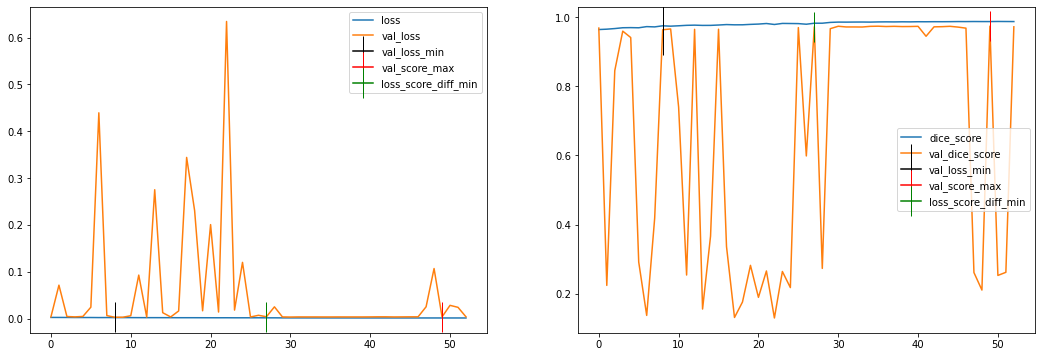

In [12]:
import csv
import shutil
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

result_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
result_weights = glob(f'{result_path}/weights/*')

with open(f'{result_path}/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

loss_min_epoch = np.argmin(dict_from_csv['val_loss']) + 1
loss_min_loss = np.min(dict_from_csv['val_loss'])
loss_min_accuracy = dict_from_csv['val_dice_score'][loss_min_epoch - 1]

score_max_epoch = np.argmax(dict_from_csv['val_dice_score']) + 1
score_max_loss = dict_from_csv['val_loss'][score_max_epoch - 1]
score_max_accuracy = np.max(dict_from_csv['val_dice_score'])

min_epoch = 15
val_score = dict_from_csv['val_dice_score'][min_epoch:]
score_diff = np.array(dict_from_csv['dice_score'] - np.array(dict_from_csv['val_dice_score']))[min_epoch:]
score_diff = np.maximum(score_diff, 0)

loss_score_diff_min_epoch = np.argmax(val_score - score_diff) + 1 + min_epoch
loss_score_diff_min_loss = dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1]
loss_score_diff_min_accuracy = dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1]

print(f"val_loss_min (epoch, loss, accuracy): ({loss_min_epoch}, {loss_min_loss:.4f}, {loss_min_accuracy:.4f})")
print(f"val_dice_score_max (epoch, loss, accuracy): ({score_max_epoch}, {score_max_loss:.4f}, {score_max_accuracy:.4f})")
print(f"loss_score_diff_min (epoch, loss, accuracy): ({loss_score_diff_min_epoch}, {loss_score_diff_min_loss:.4f}, {loss_score_diff_min_accuracy:.4f})")

_, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(dict_from_csv["loss"])
ax[0].plot(dict_from_csv["val_loss"])
ax[0].plot(loss_min_epoch - 1, loss_min_loss, marker="|", color="black", markersize=30)
ax[0].plot(score_max_epoch - 1, dict_from_csv['val_loss'][score_max_epoch - 1], marker="|", color="red", markersize=30)
ax[0].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[0].legend(["loss", "val_loss", "val_loss_min", "val_score_max", "loss_score_diff_min"])

ax[1].plot(dict_from_csv["dice_score"])
ax[1].plot(dict_from_csv["val_dice_score"])
ax[1].plot(loss_min_epoch - 1, dict_from_csv['val_dice_score'][loss_min_epoch - 1], marker="|", color="black", markersize=50)
ax[1].plot(score_max_epoch - 1, score_max_accuracy, marker="|", color="red", markersize=30)
ax[1].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[1].legend(["dice_score", "val_dice_score", "val_loss_min", "val_score_max", "loss_score_diff_min"])

plt.savefig(f"{result_path}/learning curve.png", dpi=300)
plt.show()
plt.close()

In [8]:
best_loss_path = glob(f"{result_path}/weights/weights_{loss_min_loss:.4f}_*.hdf5")[0]
shutil.copy(best_loss_path, f"{result_path}/epoch_{loss_min_epoch}_loss_{loss_min_loss:.4f}_dice_{loss_min_accuracy:.4f}.hdf5")
print(best_loss_path)

model.load_weights(best_loss_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-22/gpu_0/target_size_(512, 512)//weights\weights_0.5817_0.5809_03.hdf5
8007/8007 [==============================] - 301s 37ms/step - loss: 0.6196 - dice_score: 0.7699


[0.6196098327636719, 0.7699307799339294]

In [9]:
best_score_path = glob(f"{result_path}/weights/*_{score_max_epoch:02d}.hdf5")[0]
shutil.copy(best_score_path, f"{result_path}/epoch_{score_max_epoch}_loss_{score_max_loss:.4f}_dice_{score_max_accuracy:.4f}.hdf5")
print(best_score_path)

model.load_weights(best_score_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-22/gpu_0/target_size_(512, 512)//weights\weights_0.6028_0.5243_17.hdf5
8007/8007 [==============================] - 274s 34ms/step - loss: 0.6730 - dice_score: 0.8638


[0.673039436340332, 0.8637886643409729]

In [10]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-22/gpu_0/target_size_(512, 512)//weights\weights_0.6028_0.5243_17.hdf5
8007/8007 [==============================] - 278s 35ms/step - loss: 0.6730 - dice_score: 0.8638


[0.673039436340332, 0.8637886643409729]

In [89]:
from matplotlib import pyplot as plt

current_data_loader = test_data_loader
index = 0
image_array, mask_array = current_data_loader.data_getter[index].values()
image_array = np.expand_dims(image_array, axis=0)
image_array = (image_array / 127.5) - 1

predicted_array = model.predict(image_array)[0,:,:,0]

image_array = (image_array + 1) * 127.5
image_array = image_array.astype("uint8")[0]

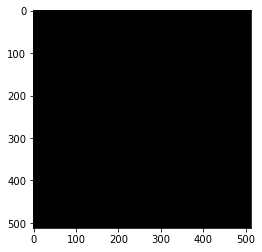

In [90]:
plt.imshow(image_array)

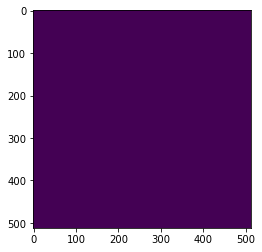

In [91]:
plt.imshow(mask_array)

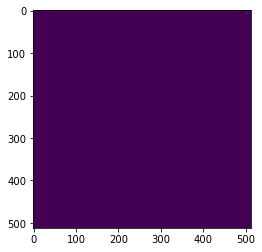

In [92]:
plt.imshow(predicted_array)

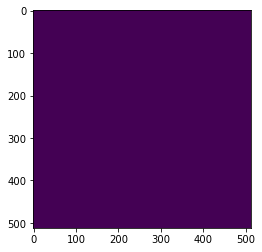

In [93]:
plt.imshow(predicted_array > 0.5)

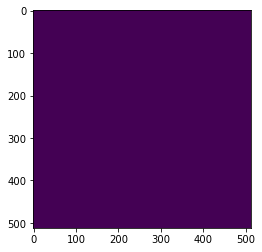

In [94]:
plt.imshow(predicted_array > 0.1)

# Unused Code

In [8]:
import csv

with open('./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/proportional_dice_focal_loss/blur/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']


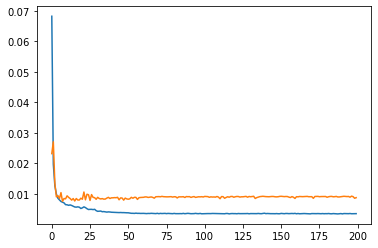

In [20]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.plot(dict_from_csv["val_loss"])
plt.show()

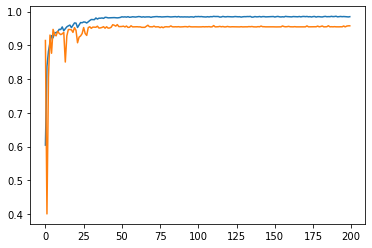

In [16]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()